# Custom Baseline Fitting

dysh includes a baseline fitting method for its [``Spectrum``](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum) objects, the [``baseline``](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum.baseline) function.
For simplicity, [``baseline``](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum.baseline) uses [``astropy.modeling.polynomial``](https://docs.astropy.org/en/stable/modeling/polynomial_models.html) as models.
However, it is possible to fit any [``astropy.modeling.Model``](https://docs.astropy.org/en/stable/api/astropy.modeling.Model.html#astropy.modeling.Model) with some extra steps.
Here we describe one possible approach.

Under the hood, the [``baseline``](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum.baseline) method uses [``specutils.fitting.fit_continuum``](https://specutils.readthedocs.io/en/stable/api/specutils.fitting.fit_continuum.html#specutils.fitting.fit_continuum), which can take as input any [``astropy.modeling.Model``](https://docs.astropy.org/en/stable/api/astropy.modeling.Model.html#astropy.modeling.Model).
We can leverage this functionality to fit a custom model.

To illustrate this, we will create some fake data and then fit it.

## Loading Modules
We start by loading the modules we will use to create the fake data and the baseline fit.

In [1]:
import numpy as np

from dysh.spectra import Spectrum
from specutils.fitting import fit_continuum
from astropy import modeling
from astropy import units as u

## Make Fake Data

We create a [``Spectrum``](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum) object.
This would be the result of time averaging some calibrated data.

In [2]:
spectrum = Spectrum.fake_spectrum()

Next, we add a power law to it, to represent a type of model that is not one of ``astropy.modeling.polynomial`` models.
We use a power law with an exponent, ``alpha``, of -12.7 and an amplitude of 10 K at the first channel of the spectrum, ``x_0``.

In [3]:
amplitude = 10 * u.K
alpha = -12.7
x_0 = spectrum.spectral_axis.quantity[0]
power_law_values = amplitude * np.power(spectrum.spectral_axis.quantity / x_0, alpha)

We add the power law to our spectrum.
This will be our starting point for the fit.

In [4]:
spectrum += power_law_values

See how it looks.

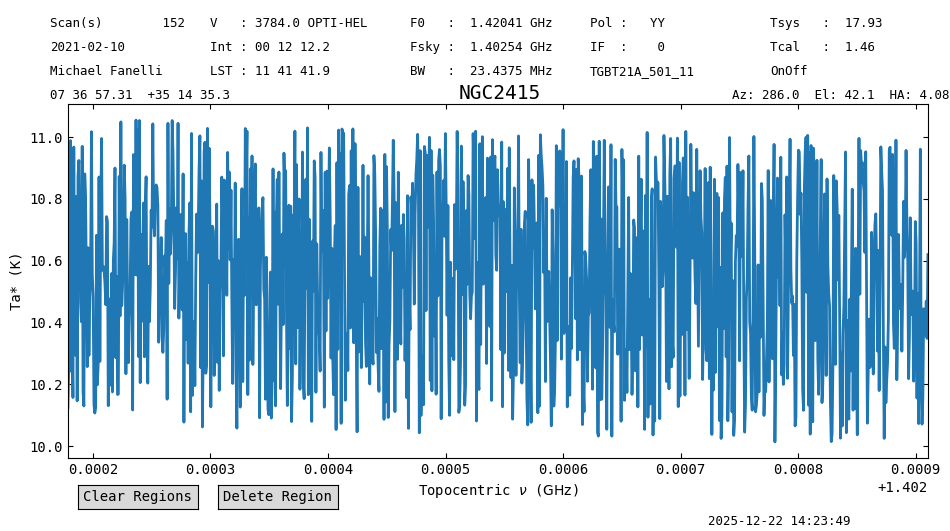

In [5]:
plot = spectrum.plot(xaxis_unit="GHz")

The power law is not obvious, as our spectrum only covers a small frequency range.
But we know it is there, because the spectrum is offset from zero and it has a slope.

## Custom Model Fitting

Now we define our model using ``astropy.modeling``.
When we define our model we must specify the starting guess for the model parameters.
We will use starting values not too far from the answer.

In [6]:
model = modeling.powerlaws.PowerLaw1D(amplitude=5*u.K, 
                                      x_0=spectrum.spectral_axis.quantity[0],
                                      alpha=-10.)

Now, we use this model to fit our spectrum.

In [7]:
model_fit = fit_continuum(spectrum, model=model)

The return from ``fit_continuum`` is our model with the best fit parameters.

In [8]:
model_fit

<PowerLaw1D(amplitude=11.49160513 K, x_0=1.39340585e+09 Hz, alpha=13.09247682)>

Now, we evaluate the model over the same frequency range as our spectrum and plot it on top of the data.
To add it to the plot we leverage the ``SpectrumPlot.axis`` attribute, which is the ``matplotlib.axes.Axes`` object that contains the plotted elements.

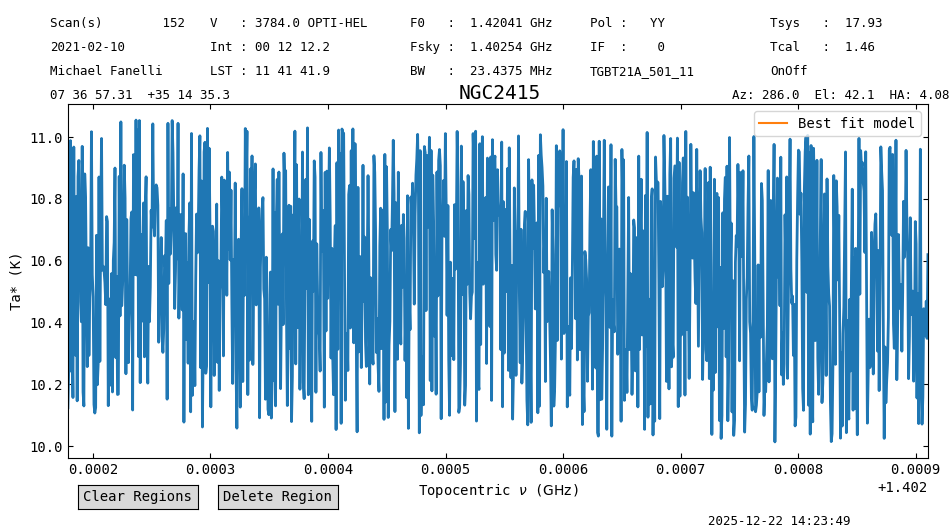

In [9]:
model_fit_values = model_fit(spectrum.spectral_axis)
plot.axis.plot(spectrum.spectral_axis, model_fit_values, label="Best fit model")
plot.axis.legend()
plot.figure

So, even if the best fit ``alpha`` was far from the input, this model still describes the fake data reasonably well.

## Model Removal
We can remove this baseline model from the spectrum using arithmetic:

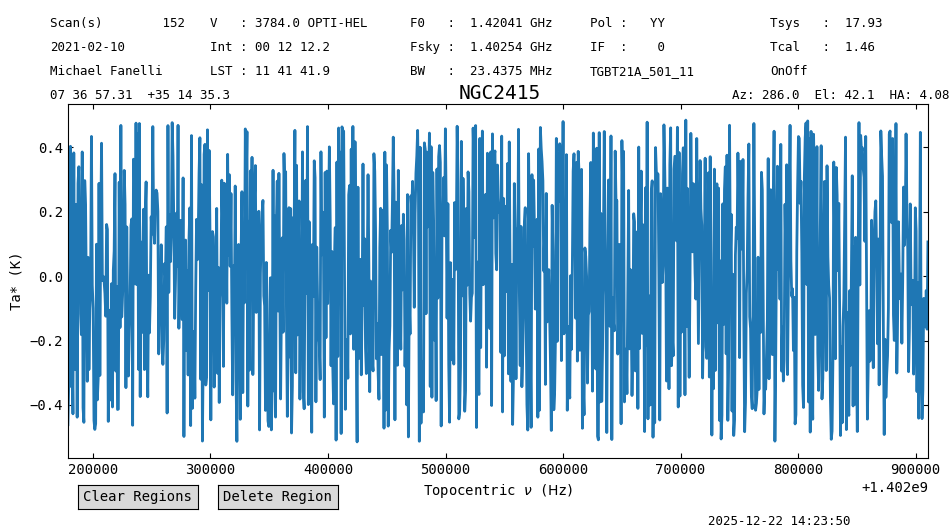

In [10]:
baseline_removed_spectrum = spectrum - model_fit_values
baseline_removed_spectrum.plot();

The baseline model has been removed from ``baseline_removed_spectrum``, as the spectrum is now centered around zero. 

Please check [``astropy.modeling``](https://docs.astropy.org/en/stable/modeling/index.html) for more models and additional options that can be used during the fitting.